# CSI 5238 Homework Exercise 1

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from pprint import pprint
import torch
import torch.nn as nn
from torch.autograd import Variable
from sklearn import preprocessing
torch.set_default_tensor_type('torch.DoubleTensor')

### Generate input and output
Generate random input x between 0 and 1 exclusively, and generate out using function f(x).

In [2]:
def gaussianRan(sigma, mu=0):
    # standard normal distribution of mean 0 variance 1
    # For random samples from N(\mu, \sigma^2), use
    return sigma*np.random.randn() + mu

Test gaussian random distribution.

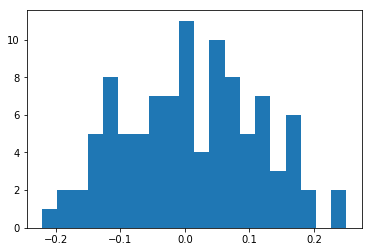

In [3]:
n, sigma = 100, 0.1
x = np.array([gaussianRan(sigma) for x in range(n)])

bins = int(n/5)
plt.hist(x, bins)
plt.show()

In [4]:
def functionx(x, sigma):
    return np.cos(2*np.pi*x) + gaussianRan(sigma)

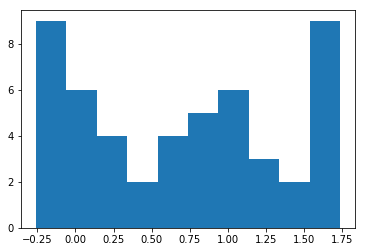

In [5]:
# Test functionx
n, sigma = 50, 1
x = np.random.uniform(low=0, high=1, size=(n,1))
y = functionx(x, sigma)

bins = int(n/5)
plt.hist(y, bins)
plt.show()

In [6]:
def getData(n, sigma, is_numpy=False, preprocess=False):
    x = np.random.uniform(low=0, high=1, size=(n,1))
    y = functionx(x, sigma)
    
    if preprocess:
        x = preprocessing.scale(x)
        y = preprocessing.scale(y)
    
    if is_numpy:
        return x, y
    return Variable(torch.from_numpy(x)), Variable(torch.from_numpy(y))

Graph input and output results.

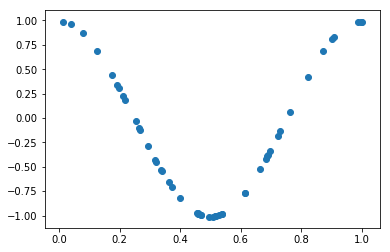

In [7]:
n = 50
sigma = 0.01
x, y = getData(n, sigma, is_numpy=True, preprocess=False)

plt.scatter(x, y)
plt.show()

### Define loss function, polynomial feature function, linear regression model

In [247]:
def getMSE(y_pred, y, w, lambd, is_numpy=False):
    if is_numpy:
        m = w.size
        return np.mean((y_pred - y)**2) + lambd*(1/m)*np.mean((np.dot(w.T, w)))
    
    m = w.size()[1]
    return torch.mean((y_pred - y)**2) + lambd*(1/m)*((torch.mm(w.t(), w))[0][0])

In [162]:
# Test getMSE
y_pred = torch.Tensor([[1.5],[1]])
y = torch.Tensor([[2],[2]])
w = torch.Tensor([[1],[1]])
lambd = 1
print(getMSE(y_pred, y, w, lambd))
print(torch.mean((y_pred - y)**2))
print(torch.mm(w.t(), w)[0][0])

tensor(2.6250)
tensor(0.6250)
tensor(2.)


In [143]:
def polynomialx(x, d, is_numpy=False):
    if d == 0:
        x = np.zeros_like(x)
    else:
        poly = preprocessing.PolynomialFeatures(d, include_bias=False)
        x = poly.fit_transform(x)
        
    if is_numpy is False:
        x = torch.from_numpy(x)
    return x

In [144]:
# Test polynomialx
x = np.array([[2], [3], [4]])
d = 0
print(polynomialx(x,d))

tensor([[0],
        [0],
        [0]], dtype=torch.int32)


In [145]:
class LrModule(nn.Module):

    def __init__(self, d):
        super(LrModule, self).__init__()
        if d == 0: d = 1
        self.linear = nn.Linear(d,1)

    def forward(self, x):
        # linear
        return self.linear(x)

In [146]:
# Check LrModule
lr = LrModule(0)
print(lr.linear)

Linear(in_features=1, out_features=1, bias=True)


In [147]:
# Test getMSE
x = np.array([[1,2], [1,3], [1,4], [1,5]])
y = np.array([[7], [6], [5], [4]])
w = np.array([[0.1], [0.2]])
y_pred = np.dot(x,w)
res = getMSE(y_pred, y, w, lambd=0, is_numpy=True)
assert res == 23.89

### Gradient Checking

In [148]:
def gradApprox(lr, x, y, lambd, e=1e-2):
    w = lr.linear.weight.data
    w = w.detach().numpy()
    y = y.detach().numpy()
    dwa = np.zeros_like(w)
    
    i = 0
    for val in w[0]:
        wp, wm = w.copy(), w.copy()

        wp[0][i] += e
        wm[0][i] -= e
        
        lr.linear.weight.data = torch.from_numpy(wp)
        y_pred = lr.forward(x)
        y_pred = y_pred.detach().numpy()
        jp = getMSE(y_pred, y, wp, lambd, is_numpy=True)
        
        lr.linear.weight.data = torch.from_numpy(wm)
        y_pred = lr.forward(x)
        y_pred = y_pred.detach().numpy()
        jm = getMSE(y_pred, y, wm, lambd, is_numpy=True)

        dwa[0][i] = (jp - jm)/(2*e)
        i += 1
    
    return dwa

In [165]:
def checkGrad(lr, x, y, lambd):
    dw = lr.linear.weight.grad
    dw = dw.detach().numpy()
    dwa = gradApprox(lr, x, y, lambd)
    print("*****************************************")
    print("dw: ", dw)
    print("dwa:", dwa)
    e = np.linalg.norm(dw-dwa)/(np.linalg.norm(dw) + np.linalg.norm(dwa))
    print("Grad approx error: ", e)
    print("*****************************************")

In [168]:
# Test LrModule gradient
lr = LrModule(3)
x = torch.Tensor([[8,1,6],[3,5,7],[4,9,2]])
y = torch.Tensor([[7],[6],[5]])
w = torch.Tensor([[0.2, 0.3, 0.4]])
b = torch.Tensor([0.1])
lambd = 0
learning_rate=1e-2

lr.linear.weight.data = w
lr.linear.bias.data = b
print("w: ", lr.linear.weight.data)
print("b: ", lr.linear.weight.data)
y_pred = lr.forward(x)
cost = getMSE(y_pred, y, w, lambd)
print("Cost: ", cost)
cost.backward()
dw, db = lr.linear.weight.grad, lr.linear.bias.grad
print("dw: ", dw)
print("db: ", db)

# grad checking
checkGrad(lr, x, y, lambd)

w:  tensor([[0.2000, 0.3000, 0.4000]])
b:  tensor([[0.2000, 0.3000, 0.4000]])
Cost:  tensor(2.7067, grad_fn=<ThAddBackward>)
dw:  tensor([[-17.4667,  -8.6667, -15.8667]])
db:  tensor([-2.8000])
*****************************************
dw:  [[-17.46666667  -8.66666667 -15.86666667]]
dwa: [[-17.46666667  -8.66666667 -15.86666667]]
Grad approx error:  2.6439547406212775e-16
*****************************************


### Learned model

In [281]:
def fitData(x, y, d, sigma, lambd=0, learning_rate=1e-1, itera=1000, n_test=1000, check_grad=False):  
    # create polynomial x matrix
    x = polynomialx(x, d)
    
    # keep track of cost for testing
    cost_hist = []
    it_hist = []
    
    lr = LrModule(d)
    
    for i in range(itera):
        #if i == 100:
        #    learning_rate = 1e-1
        # clear grads
        lr.zero_grad()
        
        # Forward
        y_pred = lr.forward(x)
        
        # loss
        w = lr.linear.weight
        #print(w)
        cost = getMSE(y_pred, y, w, lambd)
        
        # Backward for derivative
        cost.backward()
        
        # Gradient checking
        if check_grad and i>20:
            checkGrad(lr, x, y, lambd)
            break
        
        # Update gradient
        lr.linear.weight.data -= learning_rate*lr.linear.weight.grad.data
        lr.linear.bias.data -= learning_rate*lr.linear.bias.grad.data
        
        # Save cost history for testing
        cost_hist.append(cost.detach().numpy())
        it_hist.append(i)
    
    w = lr.linear.weight.data
    
    # Calculate Ein
    Ein = getMSE(lr.forward(x), y, w, lambd)
    
    # Create test dataset
    x_test, y_test = getData(n_test, sigma)
    
    # Create x_test dimension d
    x_test = polynomialx(x_test, d)
    
    # Calculate Eout
    Eout = getMSE(lr.forward(x_test), y_test, w, lambd)
    
    return Ein.detach().numpy(), Eout.detach().numpy(), lr, [it_hist, cost_hist]

y_pred and y


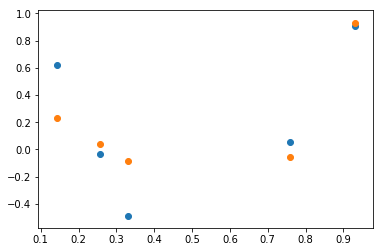

Ein:  0.06756576112922921
Eout:  0.1713353733847283
Loss function vs iterations


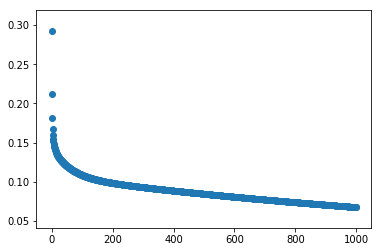

In [282]:
# Test fitData 
d, sigma, n, lambd = 19, 0.1, 5, 0.005
x, y = getData(n,sigma)
Ein, Eout, lr, plot_data = fitData(x, y, d, sigma, lambd=lambd, check_grad=False)

x_poly = polynomialx(x, d)
y_pred = lr.forward(x_poly)

print("y_pred and y")
plt.scatter(x.detach().numpy(), y.detach().numpy())
plt.scatter(x.detach().numpy(), y_pred.detach().numpy())
plt.show()

print("Ein: ", Ein)
print("Eout: ", Eout)

xx, yy = plot_data
print("Loss function vs iterations")
plt.scatter(xx, yy)
plt.show()

### Experiments

In [283]:
def experiment(n, d, sigma, lambd, trials=20, n_test=1000):
    
    # initialize
    Ein_hist, Eout_hist = np.array([]), np.array([])
    w_hist, b_hist = np.empty([d, 0]), np.array([])

    for trail in range(trials):
        Ein = 10
        while(Ein>=10):
            x, y = getData(n, sigma)
            Ein, Eout, lr, plot_data = fitData(x, y, d, sigma, lambd=lambd)
            Ein_hist = np.append(Ein_hist, [Ein])
            Eout_hist = np.append(Eout_hist, [Eout])

            if d != 0: w_hist = np.append(w_hist, lr.linear.weight.data.detach().numpy().reshape(-1,1), axis=1)
            b_hist = np.append(b_hist, lr.linear.bias.data.detach().numpy().reshape(-1,1))
    
    # Average
    Ein_avg = np.mean(Ein_hist)
    Eout_avg = np.mean(Eout_hist)
    if d != 0: w_avg = (1/trials)*np.sum(w_hist, axis=1).reshape(1,d)
    b_avg = np.mean(b_hist)
    
    # Create test dataset on averaged polynomials
    x_test, y_test = getData(n_test, sigma)
    
    # Create x_test dimension d
    x_test = polynomialx(x_test, d)
    
    # Ebias
    if d == 0:
        w_avg = torch.from_numpy(np.zeros((1,1)))
    else:
        w_avg = torch.from_numpy(w_avg)
#     print(w_avg)
    b_avg = torch.Tensor([b_avg])
    lr.linear.weight.data = w_avg
    lr.linear.bias.data = b_avg
    Ebias = getMSE(lr.forward(x_test), y_test, w_avg, lambd)
    Ebias = Ebias.detach().numpy()
    Ebias = float(Ebias)
    
    return Ein_avg, Eout_avg, Ebias

In [284]:
# Test experiment 
d, sigma, n, lambd = 1, 0.01, 5, 1
Ein_avg, Eout_avg, Ebias = experiment(n, d, sigma, lambd)

print("Ein_avg: ", Ein_avg)
print("Eout_avg: ", Eout_avg)
print("Ebias: ", Ebias)

Ein_avg:  0.3787055424008372
Eout_avg:  0.601510813162223
Ebias:  0.5201234083430518


### Initialize parameters for experiment
The experiment runs through combinations of different sized input, deg of features, and sigmas for f(x). A regularization rate lamba is also set. Lambda is 0 if regularization is not used.

In [285]:
bigN = [2, 5, 10, 20, 50, 100, 200]
deg = list(range(0,21))
sigmas = [0.01, 0.1, 1]
lambd = 0.005
# bigN = [50]
# deg = [4]
# sigmas = [1]

numCombinations = len(bigN)*len(deg)*len(sigmas)
print(numCombinations)

441


In [ ]:
experiments = []

cntCombinations = 0
print("Number combinations: ", numCombinations)

for n in bigN:
    for d in deg:
        for sigma in sigmas:
            cntCombinations+=1
            Ein_avg, Eout_avg, Ebias = experiment(n, d, sigma, lambd, trials=10)
            
#             print("Experiment ", cntCombinations)
#             print("Inputs N, d, sigma: %s, %s, %s" % (n, d, sigma))
            print("%s, %s, %s" % (Ein_avg, Eout_avg, Ebias))
            experiments.append([n, d, sigma, Ein_avg, Eout_avg, Ebias])

print("done")
#'''
# save experiment
with open(".\experiments\experiments_reg", 'w', encoding="utf-8") as fout:
    pprint(experiments, fout)
#'''

Number combinations:  441
0.32805160819443524, 0.7456470110623592, 0.5262949708411658
0.3703036078262466, 0.7753096423322364, 0.5855393243579957
0.13077662996310996, 2.6750682776428603, 2.0667947269491447
0.034486083927144945, 1.1955038813462395, 0.7577915053059817
0.048478708770680334, 1.4414144032633842, 0.8708945616507603
0.039027615827672474, 4.503101528740088, 1.754832769648572
0.005267407871691223, 1.4420103880630175, 0.7776509184825768
0.011742891203674806, 2.074497418602628, 0.8990528778610477
0.007309283895637999, 3.5130847336273496, 2.0258700566321375
0.0070745144150202765, 2.139073690093867, 0.7767166863660177
0.007490613385939124, 2.6795837042458297, 1.0938627894815955
0.0029541119154758936, 2.162132206457624, 0.9864632935114904
0.007619078090899023, 1.8792463707638958, 0.8737310649146834
0.004880962488369133, 2.8399688556411826, 1.0875922232086512
0.0013530607678594873, 8.23945947280839, 0.7960593920307318
0.0046048145273397114, 1.4853546068934502, 0.5353099527505639
0.004

0.09826767628139152, 0.39762514830548057, 0.17285607489611493
0.10616191963392833, 1.6861195458675886, 1.2015331000476663
0.08677807913928316, 0.1154512886326449, 0.09245690345025823
0.08187732132068565, 0.19852869142058807, 0.12676083688700995
0.0845434149909162, 1.5109941486083436, 0.9110765994415536
0.06718974551414728, 0.17640609396432277, 0.11895075354761504
0.07433936762144654, 0.19038951874046114, 0.11198500137834752
0.0648829068805304, 1.679564192690438, 0.22026855659522168
0.08032336355253747, 0.1986916871681314, 0.14544741830142988
0.0677319088126643, 0.27262660983615794, 0.15461793003675292
0.079048666782582, 3.5898904796935334, 1.5595525889938977
0.06205167875249309, 0.2379981330991105, 0.1703003759554441
0.07222963598237082, 0.28360639970083606, 0.17279685294357358
0.07782992412042358, 1.454861670468742, 0.20944437527910523
0.06384013085144825, 0.3882489081252435, 0.20417684845047487
0.06851917291226207, 0.28140662366789354, 0.1777326159483446
0.056435074813552345, 2.74250

0.10715180079027668, 0.8329437973038534, 0.26810200514050964
0.10573343449705434, 0.13265928045127226, 0.12379219522214358
0.10097843451645958, 0.14618789819008043, 0.12739775138163686
0.1129072610324369, 3.2855540296237713, 4.330284906686542
0.1000792038299488, 0.1376527358097341, 0.1081850403427029
0.09300218020096238, 0.16008831242322738, 0.12264758166366746
0.10302875593541547, 1.8339971746831778, 2.656736592978564
0.09524968555073612, 0.12079766678811954, 0.11306946037190291
0.09657931994505117, 0.12391420270990554, 0.10491055175434726
0.09446163525189591, 1.12355265216998, 0.9693477803516082
0.08513701759472464, 0.10352607024360368, 0.09221801710938085
0.08617950519353682, 0.10548496302713888, 0.08879690422275403
0.08528610468314257, 3.037395067912572, 0.6154213842082946
0.07734131250577356, 0.08283557874281318, 0.0798240083860039
0.078892014013051, 0.1024631353913182, 0.11123359108854342
0.07936129631644745, 2.4922341657350926, 0.7590142037005305
0.06714921142615513, 0.080274917